In [1]:
import copy 
import scipy
import numpy as np
import pandas as pd

import scipy.linalg as sla 
import numpy.linalg as la 
import matplotlib.pyplot as plt

from scipy.linalg import solve_continuous_are as CARE

# Make sure we can import required slycot routine
try:
    from slycot import sg02ad
except ImportError:
    raise print("Can't find slycot module 'sg02ad'")
    
from utils import *
from dynsys import * 
from identify import * 

import sys, os 

sys.path.append("sysidentpy")
from sysidentpy.narmax_base import InformationMatrix
from sysidentpy.model_structure_selection import (FROLS, FROLS2)
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

### Generating a 3-input-1-output sampled data from a car cruise control model

$$
m \dfrac{dv}{dt} = \alpha_n u T (\alpha_n v) - m g C_r sgn(u) - \dfrac{1}{2} \rho C_d A |v| v - mg \sin \theta
$$

where 

+ $v$ is the velocity profile of the vehicle, aka the state;
+ $m$ is the mass of the vehicle;
+ $\alpha_n$ is the effective wheel radius of the vehicle;
+ $T$ is the vehicle's torque, 
    + controlled by the throttle $u$;
+ $C_r$ is the rolling friction coefficient;
+ $C_d$ is the aerodynamic drag constant for a vehicle of area $A$;
+ $\theta$ is the road curvature, modeled as a Wiener process;

This model is adopted from R.M. Murray's Feedback Systems book, section 4.1.


Let $x := v, \, u_1 := u, \, u_2:= \alpha_n$, and $u_3 := \theta$. Then, The state space equation is

\begin{align}
m \dot{x} &= u_2 u_1 T(u_1 x) - mg C_r sgn(u_1) - \dfrac{1}{2} \rho C_d A |x| x - mg \sin u_3  \\
  \dot{x} &= m^{-1} u_2 u_1 T(u_1 x) - g C_r sgn(u_1) - \dfrac{1}{2} m^{-1} \rho C_d A |x| x - g \sin u_3 
\end{align}

The torque $T$ is given by 

$$
T = T_m \left(1-\beta\left(\dfrac{\omega}{\omega_m}-1\right)^2\right)
$$

where $\beta = 0.4, \omega_m = 420$ and $T_m = 190$, so that we have 

$$
T = 190\left(1 - 0.4 \left(\dfrac{39 x}{420}-1\right)^2 \right) = 190 - 76 \left(\dfrac{39 x}{420}-1\right)^2.
$$

The true model used in data collection is given as

\begin{align}
  \dot{x} &= 0.000625 u_1 u_2 T(u_1 x) - 0.098 sgn(u_1) - 0.000312 |x| x - 9.8 \sin u_3 
\end{align}


### Get the profile of car's inputs and acceleratin throughout travel time.

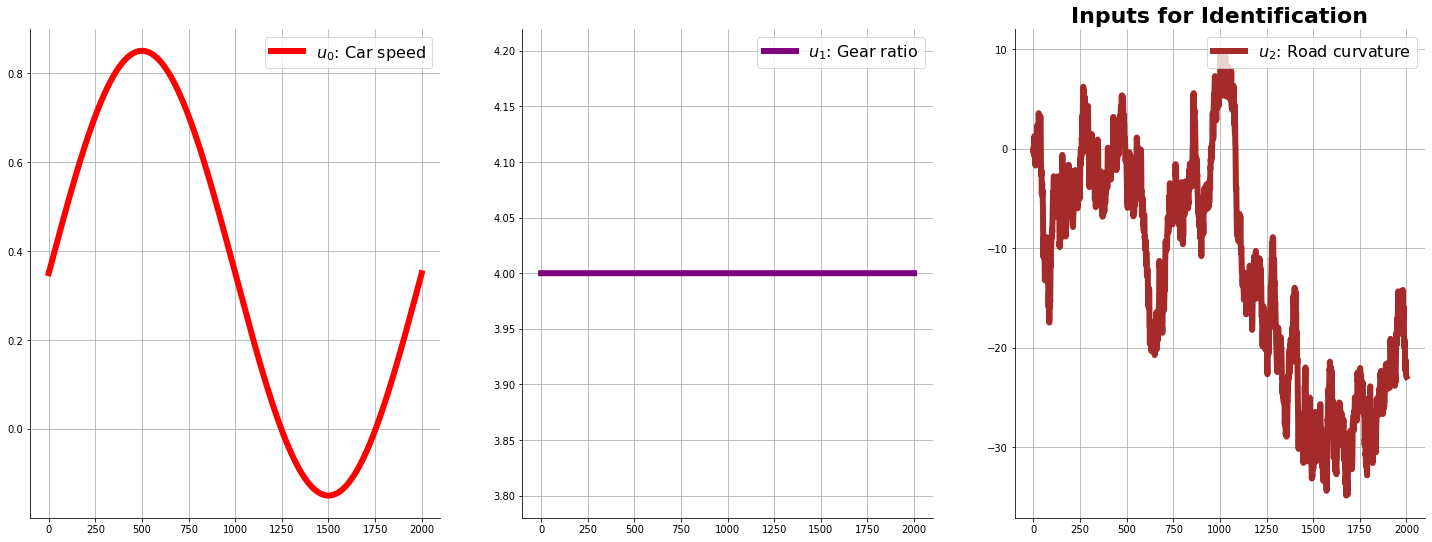

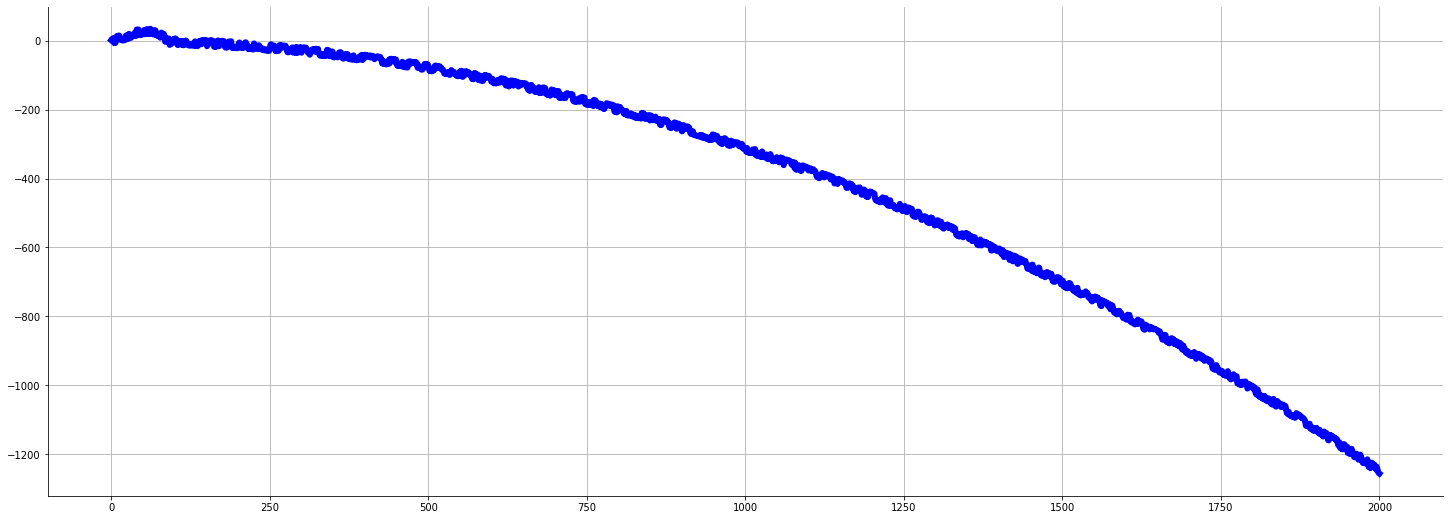

In [2]:

cruiser = CruiseControlModel(n=1, m=3, d=1)
u, x = cruiser.data_collect(ndata=2000)
T = np.linspace(0, x.size, x.size)

font = {'weight' : 'bold',
        'size'   : 22}


# show me what you got
fontdict = {"fontsize":18, "fontweight":"bold"}
colors = ["red", "purple", "brown", "blue"]
fig, ax = plt.subplots(1, 3, figsize=(25,9))
legends = ["Car speed", "Gear ratio", "Road curvature"]
for idx in range(u.shape[0]):
    ax[idx].plot(T, u[idx], label=rf"$u_{idx}$: {legends[idx]}", color=colors[idx], linewidth=6)
    ax[idx].legend(loc="upper right", fontsize=16)
    ax[idx].grid("on")
plt.title("Inputs for Identification", fontdict = font)
plt.figure(figsize=(25,9))
plt.plot(T, x, label=rf"$x$: Car acceleration $(m/s^2)$", color="blue", linewidth=6)
plt.grid("on")
plt.show()

u, x = u.T, np.expand_dims(x, 1)

### Do a NARMAX Identification from I/O data

In [7]:

ratio = int(0.8*len(u))
x_train, y_train = u[:ratio], x[:ratio]
x_test,  y_test  = u[ratio:], x[ratio:]

xlag, ylag =[[1,2,3], [1,2,3], [1,2,3]], 2

degree = 3
basis_function = CruiseControlBasis(xlag, ylag, noise_var=0.005, degree=degree, ensemble=False)

model = FROLS2(
    order_selection=True,
    n_info_values=4,
    extended_least_squares=False,
    ylag=ylag, xlag=xlag,
    info_criteria='bic',
    estimator='least_squares',
    basis_function=basis_function
)

# get regression matrix from Cruise Control Model Basis Class
reg_matrix = basis_function.fit(X=x_train, y=y_train)
# model._n_inputs = basis_function.n_inputs 
print("reg_matrix: ", reg_matrix.shape)
    
# Estimate the Theta parameters based on calculated Reg. Matrix
model.fit(X=x_train, y=y_train, reg_matrix=reg_matrix)
print()

Cruise Basis Final Regression mat:  (1600, 17)
reg_matrix:  (1599, 969)



### Model Evaluation 

In [11]:
# print([x.shape for x in (x_test, y_test)], model.max_lag)
# print(model.theta.shape, model.max_lag)

[(400, 3), (400, 1)] 1
(4, 1) 1


In [10]:
yhat = model.predict(X=x_test, y=y_test[:model.max_lag], forecast_horizon=2) 

self.theta: [[0.02326008]
 [0.02326008]
 [0.04200293]
 [0.21550013]], forecast_horizon: 2


IndexError: list index out of range

In [5]:

rrse = root_relative_squared_error(y_test, yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)
plot_results(y=y_test, yhat = yhat, n=1000)
ee = compute_residues_autocorrelation(y_test, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_test, yhat, x_test[:, 0])
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

IndexError: list index out of range

#### Generate Throttle Identification Signal

+ This is a basic sinusoid whose amplitude ranges between 0 and a (amplitude) but corrupted by noise.

In [ ]:
e = gen_white_noise(501, [0.005])
ux = np.linspace(0, 2*np.pi, e.size)
u_exp = (np.sin(ux)+0.7)/2
print(u_exp.min(), u_exp.max())

plt.figure(figsize=(20, 6))
plt.plot(u_exp, color="blue")
plt.plot(e.squeeze(), color="red")
plt.plot(e.squeeze()+u_exp, color="m")
plt.grid()
plt.legend(["Sinusoid", "White Noise", "Sin+noise"])
plt.show()


In [ ]:
Fg = m * g * np.sin(theta)
Fr  = m * g * Cr * np.array([sign(x) for x in v])
Fa = 1/2 * rho * Cd * A * abs(v) * v
dv = (F - Fg-Fa-Fr) / m
print([x.shape for x in [Fr, Fg, Fa, dv]])

In [ ]:
def solve_care(A, B1, B2, Q, R, γ, S=None, E=None, stabilizing=True, method=None, dt=0.0001):
    """
        A Continuous-time (closed-loop) Riccati equation solver for two players 
        in a zero-sum linear quadratic differential game setting.

        Solve the equation 

            :math:`AP +A^T P - P (B_1 R^{-1} B_1^T - \gamma^{-2} B_2 B_2^T) P + Q = 0`

        where A and Q are square matrices of same dimension. In addition, Q is a symmetric 
        positive definite matrix. It returns the solution P, the gain matrices, K and L, as 
        well as the closed-loop eigenvalues of (A - B_1 K + B_2 L), where K and L are the 
        feedback gains of the two players given by 

            :math: `K=R^{-1}B_1^T P,      L = -\gamma^{-2} B_2^T P.`
        
        For details, see the IFAC paper by Lekan Molu and Hosein Hasanbeig.

        Parameters
        ----------
        A, B1, B2, Q : 2D arrays
            Input matrices for the Riccati equation.
        γ : The H infinity risk measure.
        R, S, E : 2D arrays, optional
            Input matrices for generalized Riccati equation.
        method : str, optional
            Set the method used for computing the result.  Current methods are
            'slycot' and 'scipy'.  If set to None (default), try 'slycot' first
            and then 'scipy'.
        dt : float, optional
            Step size of the integration algorithm

        Returns
        -------
        X : 2D array (or matrix)
            Solution to the Ricatti equation
        V : 1D array
            Closed loop eigenvalues
        K : 2D array (or matrix) for minimizing player
        L : 2D array (or matrix) for maximizing player
            Gain matrix

        Notes
        -----
        Author: Lekan Molu
        Date: October 19, 2022
    """

    assert method is not None, "method must be 'slycot' or 'scipy'"


    # Reshape input arrays
    A = np.array(A, ndmin=2)
    B1 = np.array(B1, ndmin=2)
    B2 = np.array(B2, ndmin=2)
    Q = np.array(Q, ndmin=2)
    R = np.eye(B1.shape[1]) if R is None else np.array(R, ndmin=2)
    if S is not None:
        S = np.array(S, ndmin=2)
    if E is not None:
        E = np.array(E, ndmin=2)

    # Determine main dimensions
    n = A.shape[0]
    m = B1.shape[1]

    Rinv = la.inv(R)

    P = np.zeros((n, n))
    # initialization for stopping condition
    P0 = np.ones((n, n))
    step = 0

    while la.norm(P0-P, ord=2)>1e-8 and step < 1e7:
         step += 1
         P0 = copy.copy(P)

         P += (A.T@P0 + P0@A + Q - P0@(B1@Rinv@B1.T - 1/(γ**2)*B2@B2.T)@P0)*dt

    K = Rinv@B1.T@P
    L = 1/(γ**2)*B2.T@P

    return P, K, L

In [ ]:
def system(dt, x, u):
    '''
    Discretized Linear Dynamics of the system dx = (Ax+Bu)dt + Ddw by E-M
    Input:
        dt: time step to 
        x: state of the system, 6 dim
        u: control input of the system, 2 dim
    Output:
        x_next: state at the next step
    '''
    A = np.concatenate((np.zeros((3,3)), np.eye(3)), axis = 1)
    A_ = np.array([[12.54, -8.26, -0.39, -0.043, 2.75, -0.36],
                   [-4.38, 36.95, -3.00, 0.086, -9.57, 2.29],
                   [-6.82, -22.94, 11.93, -0.034, 6.82, -2.86]])
    A = np.concatenate((A, A_), axis = 0)
    
    B = np.array([[-50.0, 6.12],
                  [174.4, -38.93],
                  [-124.2, 48.62]])
    B = np.concatenate((np.zeros((3,2)), B), axis = 0)
    
    D = np.concatenate((np.zeros((3,3)), np.eye(3)), axis = 0)
    
    xi = np.random.normal(0,1,3)
    x_next = x + (A@x+B@u)*dt + D@xi*np.sqrt(dt)
    
    return x_next


def int_system(dt, tf, x0, K, sigma):
    '''
    Intergrate the sde from 0 to tf
    Input:
        dt: time step to discrete the system
        tf: terminal time of the integral
        x0: initial state
        K: Controller
        sigma: magnitude of exploratory noise
    Output:
        X: state trajectory from 0 to tf
        U: input trajectory from 0 to tf
    '''
    N = int(tf/dt)
    X = np.zeros((N+1,6))
    U = np.zeros((N,2))
    X[0,:] = x0
      
    y = np.zeros(2)
    
    for i in range(N):
        t = i*dt
        y = y - y*dt + np.random.normal(0,1,2)*np.sqrt(dt)
        u = -K@X[i,:] + sigma*y
        x_next = system(dt, X[i,:], u)
        X[i+1,:] = x_next
        U[i,:] = u
        
    return X, U
        

In [ ]:
# run system and collect the data
dt = 0.001
tf = 1500.0
sigma = 10
K_init = np.array([[-257.5,	-96.0,	-39.4,	-85.6,	-37.5,	-19.8],
[-628.4,	-236.7,	-94.1,	-208.6,	-93.3,	-46.7]]) 
# x0 = np.random.normal(0,1,6)
x0 = np.zeros(6)
T = np.arange(0., tf+dt, dt)
X, U = int_system(dt, tf, x0, K_init, sigma)

plt.plot(T, X)
plt.show()

In [ ]:
# Required data matrices for learning algorithm
xn = np.size(X,1) #state dim
un = np.size(U,1) #control dim
wn = 3 #disturbance dim
n_vecv = int((xn+1)*xn/2)
n_phi = n_vecv + xn*un + 1
n_data = len(U) # the total num of data

Phi = np.zeros((n_phi, n_phi))
Xi = np.zeros((n_phi, n_vecv))

for i in range(n_data):
    phi = np.concatenate((vecv(X[i]), 2*np.kron(X[i],U[i])), axis = 0)
    phi = np.concatenate((phi, np.ones(1)), axis = 0)
    Phi += np.outer(phi,phi)*dt
    Xi += np.outer(phi,(vecv(X[i+1])-vecv(X[i])))

Phi = Phi/tf
Xi = Xi/tf    
Phi_inv = np.linalg.pinv(Phi)
        

In [ ]:
A = np.concatenate((np.zeros((3,3)), np.eye(3)), axis = 1)
A_ = np.array([[12.54, -8.26, -0.39, -0.043, 2.75, -0.36],
    [-4.38, 36.95, -3.00, 0.086, -9.57, 2.29],
    [-6.82, -22.94, 11.93, -0.034, 6.82, -2.86]])
A = np.concatenate((A, A_), axis = 0)

B = np.array([[-50.0, 6.12],
    [174.4, -38.93],
    [-124.2, 48.62]])
B = np.concatenate((np.zeros((3,2)), B), axis = 0)


In [ ]:
# Learning-based algorithm
Q = 1*np.eye(xn)
R = np.eye(un)
I = 20 # number of iterations for outer Loop
J = 30 # number of iterations for inner Loop
gamma = 5

D = np.concatenate((np.zeros((3,3)), 1*np.eye(3)), axis = 0)

K = np.array([[-257.5,	-96.0,	-39.4,	-85.6,	-37.5,	-19.8],
[-628.4,	-236.7,	-94.1,	-208.6,	-93.3,	-46.7]])

T_v_vs, T_vs_v  = trans_vec_vecs(xn)
T_vt = Trans_vec(un,xn)

P_storage = np.zeros((I,xn,xn)) #store the P matrices at each iteration
K_storage = np.zeros((I,un,xn)) #store the K matrices

for i in range(I):
    L = np.zeros((wn, xn))
    for j in range(J):
        LD = np.kron(np.eye(xn), np.transpose(L)@np.transpose(D)) + np.kron(np.transpose(L)@np.transpose(D), np.eye(xn))
        LD = T_v_vs@LD@T_vs_v
        KI = T_v_vs@(np.kron(np.eye(xn), np.transpose(K)) + np.kron(np.transpose(K), np.eye(xn))@T_vt)
        Q_KL = Q + np.transpose(K)@R@K - gamma**2*np.transpose(L)@L

        Lambda = Phi_inv[0:n_vecv,:]@Xi - KI@Phi_inv[n_vecv:n_vecv+xn*un,:]@Xi + LD
        P_vecs = -np.linalg.pinv(Lambda)@vecs(Q_KL)
        P = vecs_inv(P_vecs)
        L = gamma**(-2)*np.transpose(D)@P
        
    BP = Phi_inv[n_vecv:n_vecv+xn*un,:]@Xi@P_vecs
    BP = BP.reshape((xn,un))
    K = np.linalg.pinv(R)@np.transpose(BP)

    P_storage[i] = P
    K_storage[i] = K



In [ ]:

#calculate the optimal value
P_opt, K_opt, L_opt = solve_ARE(A, B, D, Q, R, gamma)



In [ ]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

P_norm = np.zeros(I)
K_norm = np.zeros(I)
for i in range(I):
    P_norm[i] = np.linalg.norm(P_storage[i]-P_opt)/np.linalg.norm(P_opt)
    K_norm[i] = np.linalg.norm(K_storage[i]-K_opt)/np.linalg.norm(K_opt)

It = np.linspace(start=0,stop=I,num=I,endpoint=False)
plt.plot(It, P_norm, '*-', linewidth=2.0, markersize=10)
plt.xlabel('Iterations', fontsize=18)
plt.ylabel('${||\hat{P}_{K_i}-P_{*}||}/{||P_{*}||}$', fontsize=18)
plt.show()

plt.plot(It, K_norm, '*-', linewidth=2.0, markersize=12)
plt.xlabel('Iterations', fontsize=18)
plt.ylabel('${||\hat{K}_{i}-K_{*}||}/{||K_{*}||}$', fontsize=18)
plt.show()

In [ ]:
# test the learned controller
sigma = 0.0
x0 = np.random.normal(0,1,6)
T = np.arange(0., 10.0+dt, dt)
X_test, U_test = int_system(dt, 10.0, x0, K, sigma)
plt.plot(T, X_test)
plt.show()

In [ ]:
print(np.linalg.eig(A-B@K))

print(K_opt)